# Data analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Constants

In [2]:
project_path=".."

ins_path=f"{project_path}/compute/tests/ins"
outs_path=f"{project_path}/compute/tests/outs"
tmp_path=f"{project_path}/compute/tests/tmp"
data_path=f"{project_path}/data"
figures_path=f"{project_path}/results/figures"

rp_cmd=f"{project_path}/compute/source/build/read_problem"
dp_cmd=f"{project_path}/compute/source/build/dynamic_programming"
gh_cmd=f"{project_path}/compute/source/build/greedy_heuristic"
knapsack_dmd=f"{project_path}/compute/source/build/knapsack"

dataset=["nk", "zkc", "zkw"] # ["nk"]
ns=[4, 10, 15, 20, 22] #, 22] # [4, 10, 15, 20, 22, 25, 27, 30] # (4 10 15 20 22 25 27 30 32 35 37 40)
methods={
    "1":("bf",    [""]),
    "2":("bab",   [""]),
    "3":("dp",    [""]),
    "4":("gh",    [""]),
    "5":("redux", [""]),
    "6":("fptas", ["", "_005", "_01", "_035"]), # ]), #
} # ("1:bf" "2:bab" "3:dp" "4:gh" "5:redux" "6:fptas")


## Helper functions

- load dataframes
- calculate error

In [3]:
def getInstanceDataframe(in_file):
    df = pd.read_csv(in_file, sep=' ', header=None)
    df.columns = [str(x) for x in df.columns]
    df = df.rename(columns = {"0": "ID", "1": "n", "2": "W"})
    df["weights"] = df.apply(lambda x: list(x[df.columns[3::2]]), axis=1)
    df["values"] = df.apply(lambda x: list(x[df.columns[4::2]]), axis=1)
    df = df.drop(df.columns[3:-2], axis=1)
    return df

def getSolutionDataframe(out_file):
    df = pd.read_csv(out_file, sep=' ', header=None)
    df.columns = [str(x) for x in df.columns]
    df = df.rename(columns = {"0": "ID", "1": "n", "2": "max_value"})
    df["solution"] = df.apply(lambda x: list(x[df.columns[3:3+df["n"][0]]]), axis=1)
    df = df.drop(df.columns[3:-1], axis=1)
    return df

def getMethodResults(tmp_file):
    df = pd.read_csv(tmp_file, sep=' ', header=None)
    df.columns = [str(x) for x in df.columns]
    df = df.rename(columns = {"0": "ID", "1": "n", "2": "max_value", df.columns[-1]: "time"})
    df["solution"] = df.apply(lambda x: list(x[df.columns[3:3+df["n"][0]]]), axis=1)
    df = df.drop(df.columns[3:-2], axis=1)
    return df

def calculateRelativeError(df_sol, row):
    difference = abs(df_sol[df_sol["ID"] == row["ID"]]["max_value"].values[0] - row["max_value"]) 
    max_value = max(df_sol[df_sol["ID"] == row["ID"]]["max_value"].values[0], row["max_value"])
    assert(difference == 0 or max_value > 0), f"difference = {difference} and max_value = {max_value}"
    rel_error = difference/max_value if (max_value > 0) else 0
    return rel_error

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# sns.relplot(...,  dashes=dash_styles,...)

def visualizeMeanAndMax(df, feature, hue, style=None, title="", dashes=dash_styles):
    for ds in dataset:
        xticks = df[ds]["n"].unique()
    
        fig, axes = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(12, 6)
        
        g = sns.lineplot(x="n", y=f"mean_{feature}", hue=hue, style=style, data=df[ds], 
            ax=axes[0], legend="full", dashes=dashes).set_title(f"Mean {title} [{ds.upper()}]")
        axes[0].set(xticks=xticks, xticklabels=xticks)
        
        sns.lineplot(x="n", y=f"max_{feature}", hue=hue, dashes=dashes, style=style, data=df[ds],
            ax=axes[1], legend="full").set_title(f"Maximum {title} [{ds.upper()}]")
        axes[1].set(xticks=xticks, xticklabels=xticks)

        fig.savefig(f"{figures_path}/{feature}_{ds}_{hue}.png")

## Load dataframes

In [4]:
%%time

dfs = {}
for ds in dataset:
    for n in ns:
        prob_key=f"{ds}{n}"
        dfs[prob_key]={}

        inst_file=f"{data_path}/{ds}/{ds.upper()}{n}_inst.dat"
#         inst_file=f"{ins_path}/{ds}/{ds.upper()}{n}_inst.dat"
        sol_file=f"{data_path}/{ds}/{ds.upper()}{n}_sol.dat"
#         sol_file=f"{outs_path}/{ds}/{ds.upper()}{n}_sol.dat"
        
        dfs[prob_key]["inst"] = getInstanceDataframe(inst_file)# (in_file)
        dfs[prob_key]["sol"] = getSolutionDataframe(sol_file)
        dfs[prob_key]["methods"] = {}
        
        for num, details in methods.items():
            name, precisions = details
            for p in precisions:
                m = f"{name}{p}"
            
#                 computed_file=f"{tmp_path}/{ds}/{ds}_{name}_{n}{p}.csv"
                computed_file=f"{data_path}/computed/{ds}/{ds}_{name}_{n}{p}.csv"
            
                dfs[prob_key]["methods"][m] = getMethodResults(computed_file) # (tmp_file)
                dfs[prob_key]["methods"][m]["error"] = dfs[prob_key]["methods"][m][["ID","max_value"]].apply(
                    lambda row: calculateRelativeError(dfs[prob_key]["sol"], row), axis=1
                )

CPU times: user 1min 43s, sys: 340 ms, total: 1min 44s
Wall time: 1min 43s


## Create Analytic dataframe

In [5]:

targets = ["time", "error"]
COLS = ["n", "mean_time", "max_time", "mean_error", "max_error", "method"]

analytic_dfs = {}
 
for ds in dataset:
    analytic_dfs[ds] = pd.DataFrame(columns=COLS)    
    for n in ns:
        prob_key=f"{ds}{n}"
        for num, details in methods.items():
            name, precisions = details
            for p in precisions:
                if p not in ["", "_035"]: continue;
                m = f"{name}{p}"

                row = {"n": [n], "method": [m]}
                for target in targets:
                    row [f"mean_{target}"] = [dfs[prob_key]["methods"][m][target].mean()]
                    row [f"max_{target}"] = [dfs[prob_key]["methods"][m][target].max()]
                
                analytic_dfs[ds] = pd.concat([
                    analytic_dfs[ds],
                    pd.DataFrame(row, columns=COLS)
                ])

## Vizualize Time Complexity

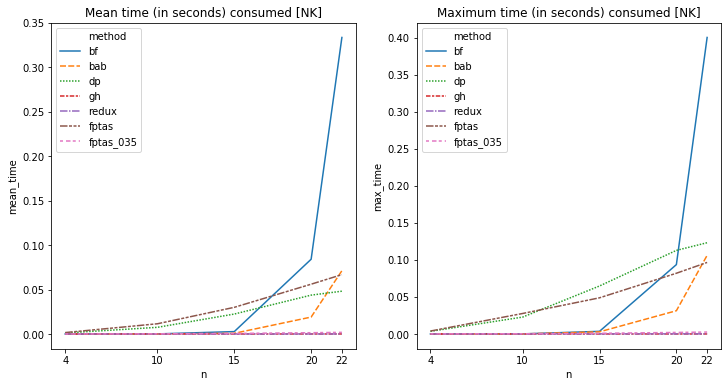

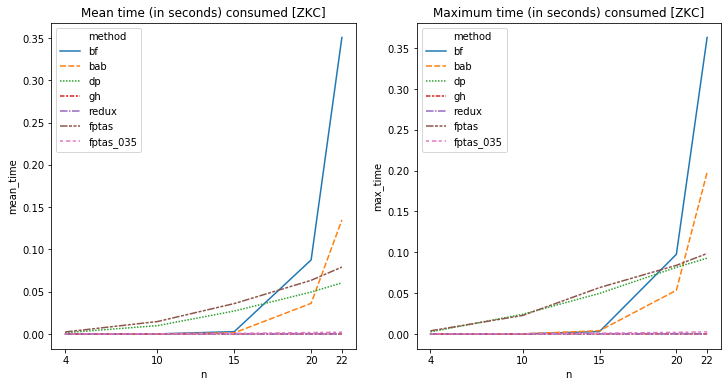

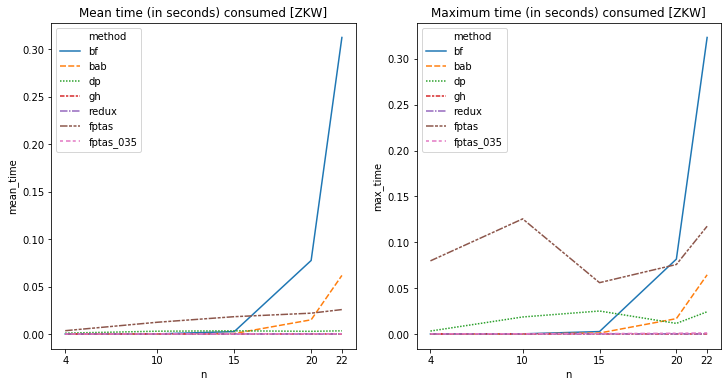

In [8]:
visualizeMeanAndMax(analytic_dfs, "time", "method", style="method", title="time (in seconds) consumed")

## Visualize Relative Error

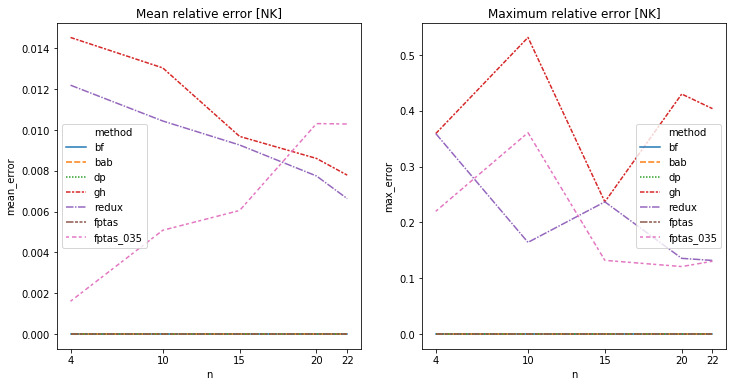

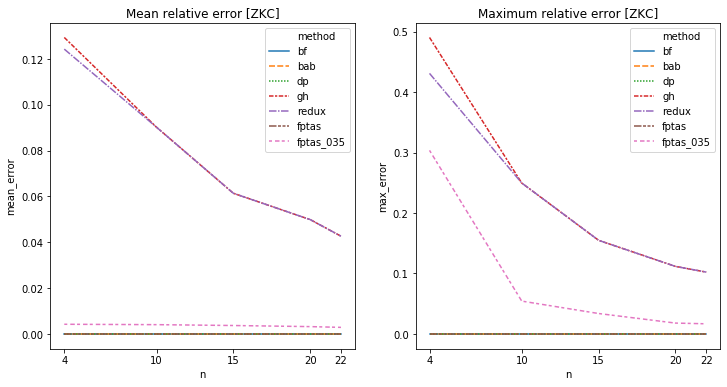

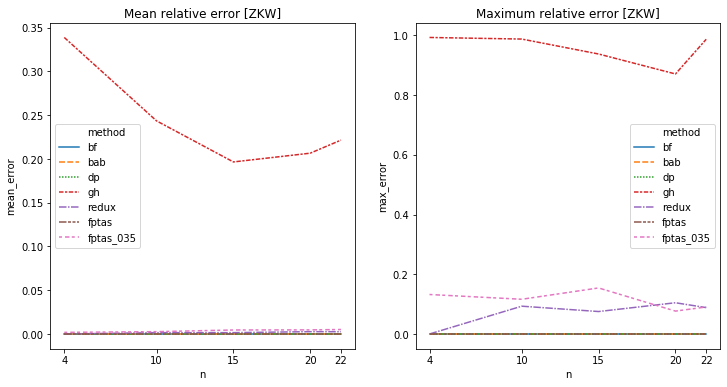

In [9]:
visualizeMeanAndMax(analytic_dfs, "error", "method", style="method", title="relative error")

## Create fptas dataframe

In [10]:

targets = ["time", "error"]
COLS = ["n", "mean_time", "max_time", "mean_error", "max_error", "method", "epsilon"]

method = "fptas"

fptas_df = {}
 
for ds in dataset:
    fptas_df[ds] = pd.DataFrame(columns=COLS)    
    for n in ns:
        prob_key=f"{ds}{n}"
        for num, details in methods.items():
            name, precisions = details
            if name != "fptas": continue;
            for p in precisions:
#                 if p not in ["", "_05"]: continue;
                m = f"{name}{p}"
                e = f"0.{p.split('_')[-1][1:]}" if (p != "") else "0"
                row = {"n": [n], "method": [m], "epsilon": [e]}
            
                for target in targets:
                    row [f"mean_{target}"] = [dfs[prob_key]["methods"][m][target].mean()]
                    row [f"max_{target}"] = [dfs[prob_key]["methods"][m][target].max()]
                
                fptas_df[ds] = pd.concat([
                    fptas_df[ds],
                    pd.DataFrame(row, columns=COLS)
                ])

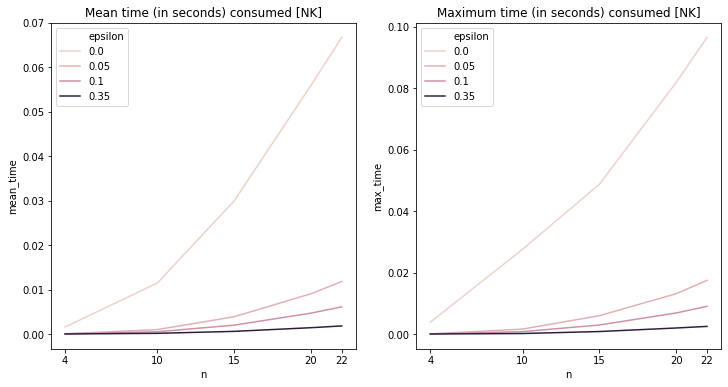

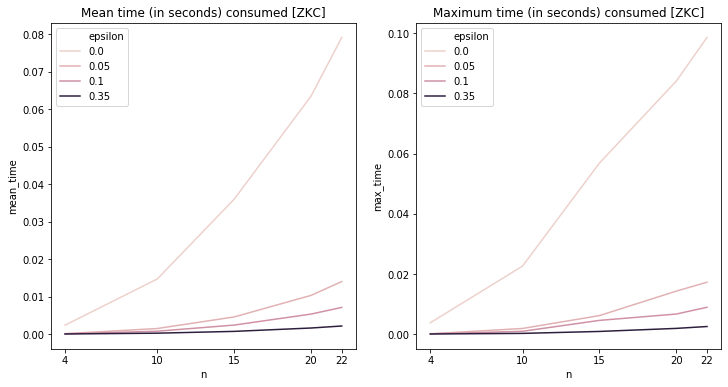

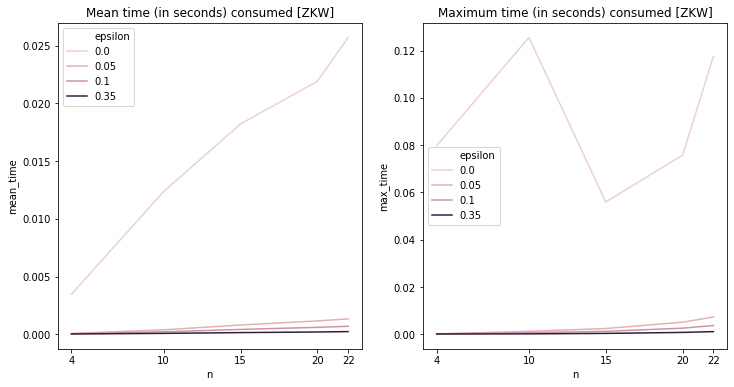

In [11]:
visualizeMeanAndMax(fptas_df, "time", hue="epsilon", title="time (in seconds) consumed")

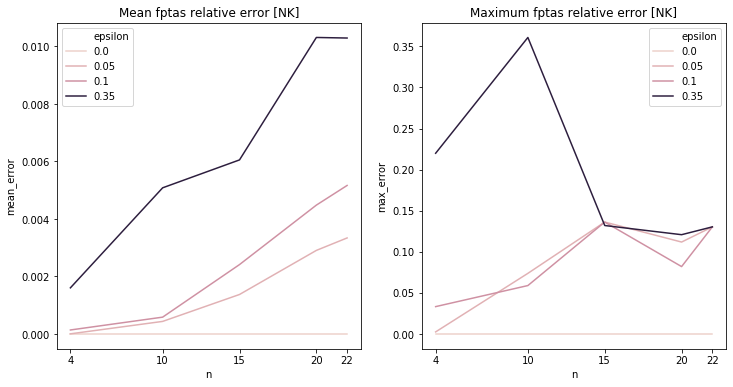

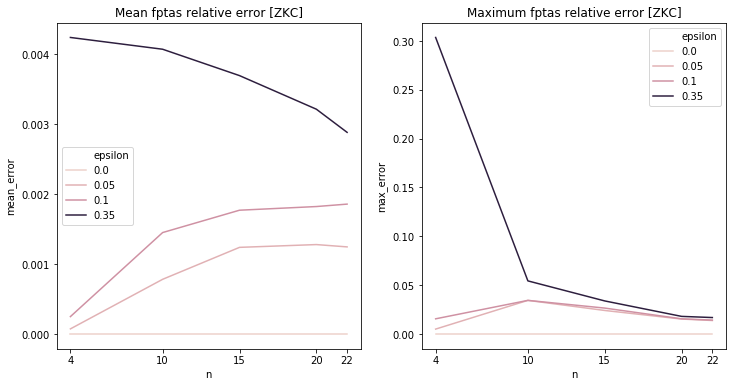

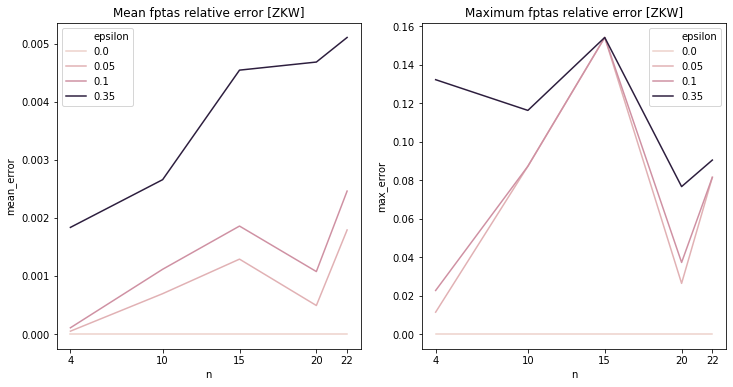

In [12]:
visualizeMeanAndMax(fptas_df, "error", hue="epsilon", title="fptas relative error")

## Tests

In [2]:
# Load dataframes

# df_isnt = getInstanceDataframe("../compute/tests/ins/nk/NK4_inst.dat")
# display(df_isnt)

# df_sol = getSolutionDataframe("../compute/tests/outs/zkc/ZKC15_sol.dat")
# display(df_sol)

# df_method = getMethodResults("../compute/tests/tmp/zkc/ZKC_redux_15.csv")
# display(df_method)

In [3]:
# Get Relative Error

# error = getRelativeError(df_sol, df_method)
# display(error.describe())
# display(dfs["zkc15"]["methods"]["redux"]["error"].describe()) #.mean())
# display(dfs["zkc4"]["methods"]["redux"]["error"].describe()) #.mean())